# Practical 6: Deep Learning for Multiclass Text Classification
#### Ayoub Bagheri
<img src="img/uu_logo.png" alt="logo" align="right" title="UU" width="50" height="20" />

#### Applied Text Mining - Utrecht Summer School

In this practical, we will apply various deep learning models for multiclass text classification. We will work with the famous 20 Newsgroups dataset from the `sklearn` library and apply deep learning models using the `keras` library.

The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. It was originally collected by Ken Lang, and it has become a popular data set for experiments in text applications of machine learning techniques.

Also, we will use the `keras` library, which is a deep learning and neural networks API by François Chollet's team capable of running on top of Tensorflow (Google), Theano or CNTK (Microsoft).

Today we will use the following libraries. Take care to have them installed!

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import LabelEncoder

from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras import layers, utils

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Let's get started!

1\. **Load the train and test subsets of the 20 Newsgroups data set from `sklearn` datasets. Remove the headers, footers and qoutes from the news article when loading data sets. Use number 321 for `random_state`.**

**In order to get faster execution times for this practical we will work on a partial data set with only 5 categories out of the 20 available in the data set: `'rec.sport.hockey'`, `'talk.politics.mideast'`, `'soc.religion.christian'`, `'comp.graphics'`, and `'sci.med'`.**

In [ ]:
categories = ['rec.sport.hockey', 'talk.politics.mideast', 'soc.religion.christian', 'comp.graphics', 'sci.med']

In [ ]:
twenty_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'),
                                  categories=categories, shuffle=True, random_state=321)
# type(twenty_train)

In [ ]:
twenty_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'),
                                 categories=categories, shuffle=True, random_state=321)

2\. **Find out about the number of news articles in the train and test sets.**

In [ ]:
twenty_train.target_names

['comp.graphics',
 'rec.sport.hockey',
 'sci.med',
 'soc.religion.christian',
 'talk.politics.mideast']

In [ ]:
twenty_train.filenames.shape

(2941,)

In [ ]:
twenty_test.filenames.shape

(1958,)

3\. **Covert the train and test to dataframes.**

In [ ]:
df_train = pd.DataFrame(list(zip(twenty_train.data, twenty_train.target)), columns=['text', 'label'])
df_train.head()

,text,label
0,\nDr. cheghadr bA namakand! They just wait un...,4
1,\n\n\n\n\n:) No...I was one of the lucky ones....,2
2,\n\n[After a small refresh Hasan got on the tr...,4
3,Before getting excited and implying that I am ...,4
4,I have posted disp135.zip to alt.binaries.pict...,0


In [ ]:
df_test = pd.DataFrame(list(zip(twenty_test.data, twenty_test.target)), columns=['text', 'label'])
df_test.head()

,text,label
0,"hi all, Ive applied for the class of 93 at qui...",2
1,:In article <enea1-270493135255@enea.apple.com...,2
2,"\nI don't know the answer the to this one, alt...",0
3,\n\nWe here at IBM have the same problem with ...,0
4,\nI was at an Adobe seminar/conference/propaga...,0


### Train a neural network a with document-term matrix

4\. **In order to feed predictive deep learning models with text data, first you need to turn the text into vectors of numerical values suitable for statistical analysis. Use the binary representation with `TfidfVectorizer` and create document-term matrices for test and train (name them `X_train` and `X_test`).**

In [ ]:
# A function for transforming train or test into tfidf features
def tfidf_features(txt, flag):
    if flag == "train":
        x = tfidf.fit_transform(txt)
    else:
        x = tfidf.transform(txt)
    x = x.astype('float16')
    return x

tfidf = TfidfVectorizer(binary=True)
X_train = tfidf_features(df_train.text.values, flag="train")
X_test = tfidf_features(df_test.text.values, flag="test")

# With CountVectorizer and without the function
# from sklearn.feature_extraction.text import CountVectorizer
# count_vect = CountVectorizer()
# X_train = count_vect.fit_transform(df_train.text.values)
# X_test = count_vect.transform(df_test.text.values)

In [ ]:
X_train.nnz / float(X_train.shape[0])

111.5678340700442

The extracted vectors are very sparse, with an average of 111 non-zero components by sample in a more than 37000-dimensional space (less than 0.3% non-zero features)

In [ ]:
X_test.nnz / float(X_train.shape[0])

75.78748724923496

In [ ]:
# tfidf.vocabulary_

5\. **Use the `LabelEncoder` to create `y_train` and `y_test` from `df_train.label.values` and `df_test.label.values`, respectively.**

In [ ]:
# Converting the list of strings to the matrix of vectors (to be fed neural network models)
# Encode the list of newsgroups into categorical integer values
lb = LabelEncoder()
y = lb.fit_transform(df_train.label.values)
y_train = utils.np_utils.to_categorical(y)

In [ ]:
y_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
y_train.shape

(2941, 5)

In [ ]:
y = lb.transform(df_test.label.values)
y_test = utils.np_utils.to_categorical(y)

6\. **Use the sequential API in `keras` and create a one-hidden-layer neural network. So, the first layer will be the input layer with the number of features in your X_train, followed by a single hidden layer, and an output layer. Set the number of neurons in the hidden layer to 5, and activation function as `relu`. For the output layer you can use a `softmax` activation function.**

The sequential API (https://www.tensorflow.org/guide/keras/sequential_model) allows you to create models layer by layer. It is limited in that it does not allow to create models that share layers or have multiple inputs or outputs.

The functional API (https://www.tensorflow.org/guide/keras/functional) allows you to create models that have a lot more flexibility as you can define models where layers connect to more than just the previous and next layers. In this way, you can connect layers to (literally) any other layer. As a result, creating complex networks such as Siamese neural networks and residual neural networks become possible.

In [ ]:
model = Sequential()
input_dim = X_train.shape[1]  # Number of features
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

7\. **The `compile` function defines the `loss` function, the `optimizer` and the evaluation `metrics`. Call this function for your neural network model with `loss='binary_crossentropy'`, `optimizer='adam'`, `metrics=['accuracy']`. Check the summary of the model.**

| Task           | Output type                       | Last-layer activation | Loss function            | Metric(s) |
| ---            | ---                               | ---                   | ---                      | ---       |
| Regression     | Numerical                         | Linear                | meanSquaredError (MSE),<br> meanAbsoluteError (MAE) | Same as loss |
| Classification | Binary                            | Sigmoid               | binary_crossentropy      | Accuracy, precision, recall, sensitivity, <br> TPR, FPR, ROC, AUC |
| Classification | Single label, Multiple classes    | Softmax               | categorical_crossentropy | Accuracy, confusion matrix |
| Classification | Multiple labels, Multiple classes | Sigmoid               | binary_crossentropy      | Accuracy, precision, recall, sensitivity, <br> TPR, FPR, ROC, AUC |

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                371490    
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
Total params: 371,545
Trainable params: 371,545
Non-trainable params: 0
_________________________________________________________________


8\. **Time to train your model! Train your model in 20 iterations. What does `batch_size` represent?**

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=512)
# model.save_weights("model.h5")
# print("Saved model to disk")

Epoch 1/20
6/6 [==============================] - 1s 25ms/step - loss: 0.6860 - accuracy: 0.2207
Epoch 2/20
6/6 [==============================] - 0s 20ms/step - loss: 0.6661 - accuracy: 0.2370
Epoch 3/20
6/6 [==============================] - 0s 22ms/step - loss: 0.6463 - accuracy: 0.2333
Epoch 4/20
6/6 [==============================] - 0s 23ms/step - loss: 0.6269 - accuracy: 0.2380
Epoch 5/20
6/6 [==============================] - 0s 22ms/step - loss: 0.6084 - accuracy: 0.2543
Epoch 6/20
6/6 [==============================] - 0s 22ms/step - loss: 0.5908 - accuracy: 0.2649
Epoch 7/20
6/6 [==============================] - 0s 23ms/step - loss: 0.5743 - accuracy: 0.2809
Epoch 8/20
6/6 [==============================] - 0s 21ms/step - loss: 0.5589 - accuracy: 0.3002
Epoch 9/20
6/6 [==============================] - 0s 20ms/step - loss: 0.5440 - accuracy: 0.3142
Epoch 10/20
6/6 [==============================] - 0s 22ms/step - loss: 0.5297 - accuracy: 0.3332
Epoch 11/20
6/6 [============

Note that if you rerun the `fit()` method, you will start off with the computed weights from the previous training. Make sure to call `clear_session()` before you start training the model again:

<br>

**`from keras.backend import clear_session` <br>
`clear_session()`**

<br>


9\. **Plot the accuracy and loss of your trained model.**

dict_keys(['loss', 'accuracy'])


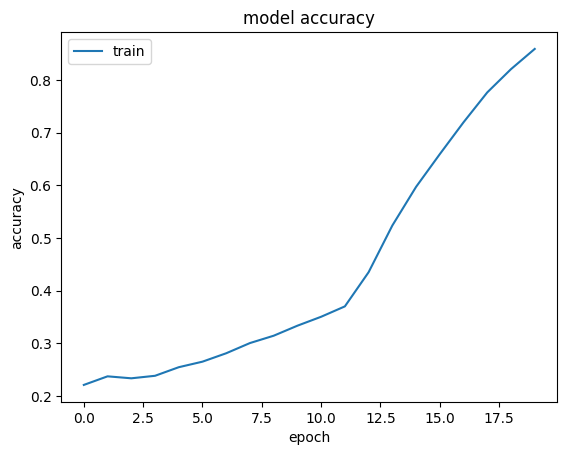

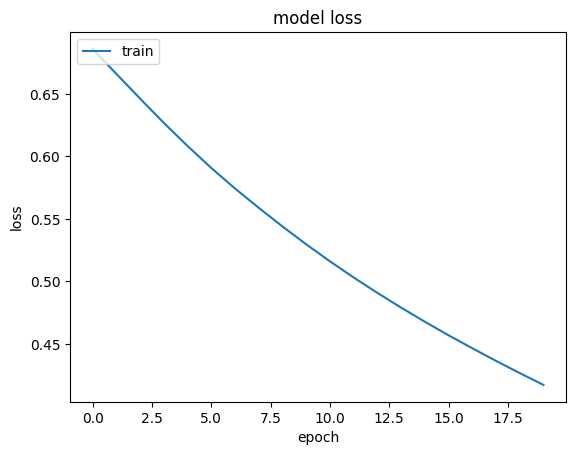

In [ ]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Here we converted the code to a function so we can use it later as well
plt.style.use('ggplot')

def plot_history(history, val=0):
    acc = history.history['accuracy']
    if val == 1:
        val_acc = history.history['val_accuracy'] # we can add a validation set in our fit function with nn
    loss = history.history['loss']
    if val == 1:
        val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    if val == 1:
        plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    if val == 1:
        plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('Loss')
    plt.legend()

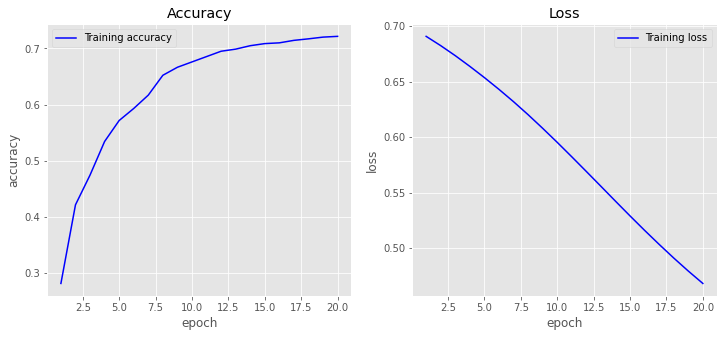

In [ ]:
plot_history(history)

10\. **Evaluate the accuracy of your trained model on the test set. Compare that with the accuracy on train.**

In [ ]:
loss, accuracy = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(loss,accuracy))

62/62 [==============================] - 0s 2ms/step - loss: 0.4427 - accuracy: 0.6977
Test set
  Loss: 0.443
  Accuracy: 0.698


You can already see that the model was overfitting since it reached over 70% accuracy for the training set. When training a model, you can use a separate testing and validation set. What you would usually do is take the model with the highest validation accuracy and then test the model with the testing set.

# The embedding layer

Here we want to create a sequential model with an embedding layer as the input layer followed by dense layers. To do this first we need to apply the `Tokenizer` from `keras` and convert the text data into sequences which can be passed into the embedding layer.

11\. **Use the tokenizer from Keras with 20,000 words and create `X-train` and `X_test` sequences.**

In [ ]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df_train.text.values)

In [ ]:
X_train = tokenizer.texts_to_sequences(df_train.text.values)
X_test = tokenizer.texts_to_sequences(df_test.text.values)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index for sequence padding
vocab_size

38111

Note that the a document-term matrix uses vectors of word counts, and each vector has the same length (the size of the total corpus vocabulary). With `keras` tokenizer, the resulting vectors equal the length of each text, and the numbers don’t denote counts, but rather correspond to the word values from the dictionary `tokenizer.word_index`.

In [ ]:
for word in ['the', 'all', 'happy', 'sad']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

the: 1
all: 35
happy: 1043
sad: 3422


12\. **Use the `pad_sequence()` function to pad each text sequence with zeros, so that each vector has the same length of 100 words.**

In [ ]:
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
print(X_train[0, :])

[  555 12221    23    75  1507   379    23    16 15253     3   621    63
  5371 10293    73  2745     5   246   686     2 10294     2  2340     4
  3927     6   332  4110  1290     3 12222   131    37     2     1    72
  7235    34   177    21     7  3928     4    33    16    35    86 12223
  3226     4    23   241   753     3 12222     3    47    38  7953    42
     4    93    17   364     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]


Typically it does not matter whether you prepend or append zeros. The first values represent the index in the vocabulary, and the rest are zeros from sequence padding, since you have a short document.

13\. **Now it is time to create a neural network model using an embedding layer as input. Take the output of the embedding layer (`embedding_dim = 50`) and plug it into a Dense layer with 10 neurons, and the `relu` activation function. In order to do this, you have to add a Flatten layer in between that prepares the sequential input for the Dense layer. Note that in the Embedding layer, `input_dim` is the size of the vocabulary, `output_dim` is the size of the embedding vector, and `input_length` is the length of the text sequence.**

In [ ]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           1905550   
                                                                 
 flatten (Flatten)           (None, 5000)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                50010     
                                                                 
 dense_3 (Dense)             (None, 5)                 55        
                                                                 
Total params: 1,955,615
Trainable params: 1,955,615
Non-trainable params: 0
_________________________________________________________________


You can now see that we have 1,905,550 new parameters to train. This number comes from vocab_size (38,111) times the embedding_dim (50). These weights of the embedding layer are randomly initialized and then are adjusted through backpropagation during training. This model takes the words as they come in the order of the sentences as input vectors.

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=64)

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9772
Testing Accuracy:  0.7594


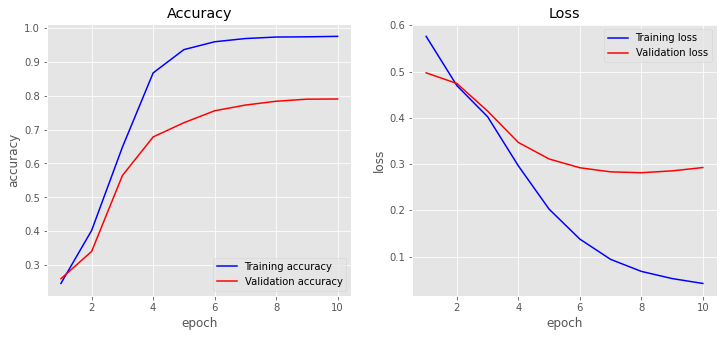

In [ ]:
plot_history(history, val=1)

# Pretrained word embeddings

14\. **Pretrained word embeddings are the embeddings learned in one task that are used for solving another similar task. These embeddings are trained on large data sets, saved, and then used for solving other tasks. Here, we are going to use the GloVe embeddings which are precomputed word embeddings simply trained on a large corpus of text. For this purpose, we wrote the following fuction to apply on the pretrained word embeddings and use the corresponding word vectors for words in our vocabulary. Download one of the GloVe embeddings (e.g. `glove.6B.50d.txt`) and create the embedding matrix using the provided function. (Link to download: https://nlp.stanford.edu/projects/glove/)**

In [36]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [40]:
embedding_matrix = create_embedding_matrix('glove.6B.50d.txt',
                                           tokenizer.word_index, embedding_dim = 50)

In [41]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.7059641573299048

15\. **Build your previous neural network model again, but this time with the initial weights from the pretrained word embeddings. Set the `trainable` argument `False` so that your embedding layer does not learn the word vectors anymore, and then again back to `True`. How does the performances change?**

In [42]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim,
                           weights=[embedding_matrix],
                           input_length=maxlen,
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 50)           1905550   
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 10)                510       
                                                                 
 dense_5 (Dense)             (None, 5)                 55        
                                                                 
Total params: 1,906,115
Trainable params: 565
Non-trainable params: 1,905,550
_________________________________________________________________


Training Accuracy: 0.7926
Testing Accuracy:  0.7829


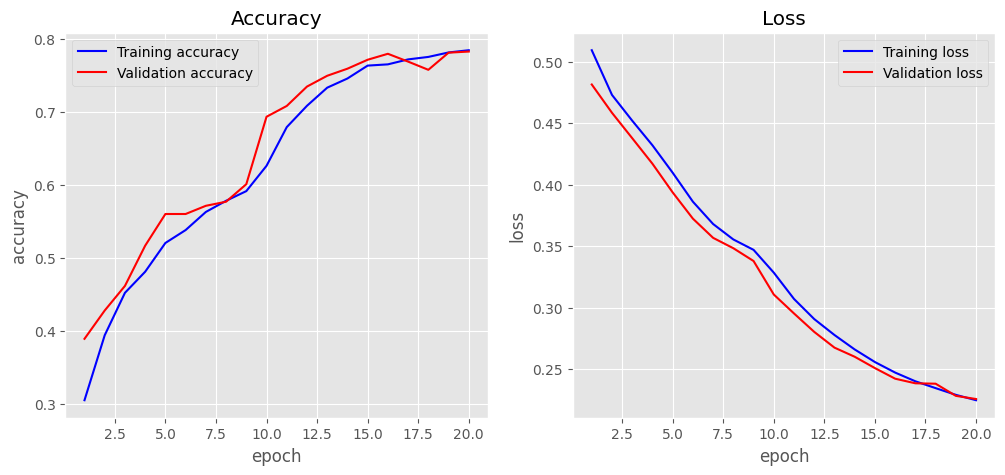

In [43]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history, val=1)

Since the word embeddings are not additionally trained, it is expected to be lower. But let’s now see how this performs if we allow the embedding to be trained by using `trainable=True`:

In [44]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim,
                           weights=[embedding_matrix],
                           input_length=maxlen,
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 50)           1905550   
                                                                 
 global_max_pooling1d_1 (Glo  (None, 50)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 10)                510       
                                                                 
 dense_7 (Dense)             (None, 5)                 55        
                                                                 
Total params: 1,906,115
Trainable params: 1,906,115
Non-trainable params: 0
_________________________________________________________________


Because it is a multiclass classification problem, log loss is used as the loss function (`categorical_crossentropy` in `keras`). The efficient ADAM optimization algorithm is used. The model is fit for 20 epochs. A large batch size of 64 reviews is used to space out weight updates.

Training Accuracy: 0.9796
Testing Accuracy:  0.8386


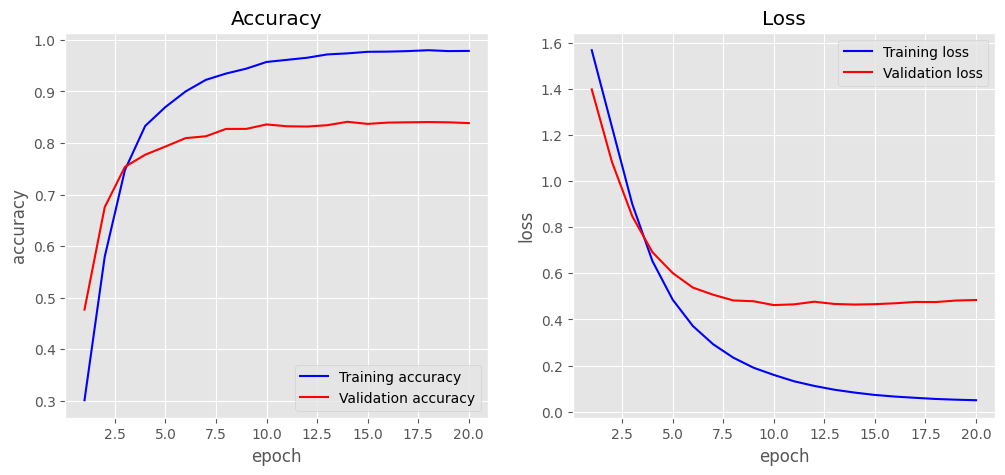

In [45]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history, val=1)